## Drive Link

https://drive.google.com/drive/folders/1Izj4ILnSGLLF_z4beHyjpzmodVMoGOkr

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# image folder path
folder = './../images'

# loads the image and converts it to rgb
def image(name):
    img = cv2.imread(folder + '/' + name)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# loads the image in grayscale format
def grayimage(name):
    img = cv2.imread(folder + '/' + name, cv2.IMREAD_GRAYSCALE)
    return img

# rgb to gray
def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# resizes image
def resize(img, size):
    return cv2.resize(img, size, interpolation = cv2.INTER_NEAREST)

# linear mapping of images to [low, high]
def lin_map(img, low=0, high=255):
    mn, mx = np.min(img), np.max(img)
    if mn == mx:
        img[:] = low
    else:
        img = (img-mn)/(mx-mn)*(high-low)+low
    return np.round(img).astype('uint8')

# log mapping of images
def log_map(img):
    img = np.log(1+img)
    return lin_map(img)

# plots image
def imshow(img, plot=plt):
    plot.imshow(img, cmap='gray', vmin=0, vmax=255)
    plot.axis('off')
    
milli_time = lambda: int(round(time.time() * 1000))

## Task 1

In [3]:
noisy = grayimage('Noisy.jpg')
noisy.shape

(240, 320)

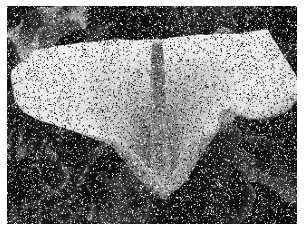

In [4]:
imshow(noisy)

### Task 1.1

Implement an algorithm for low-pass filtering a grayscale image by moving a k × k averaging filter of the form ones((k,k))/(k 2 ).

In [5]:
def add_padding(img, k1, k2):
    h, w = img.shape
    c1, c2 = k1//2, k2//2
    out = np.zeros((h+k1-1, w+k2-1), dtype=img.dtype)
    out[c1:c1+h, c2:c2+w] = img
    return out

def apply_kernel(img, kernel, pad=True):
    img = img.astype('float64')
    h, w = img.shape
    k1, k2 = kernel.shape
    
    if pad:
        img = add_padding(img, k1, k2)
        out = np.zeros((h, w))
        for i in range(h):
            for j in range(w):
                out[i][j] = np.sum(kernel * img[i:i+k1, j:j+k2])
    else:
        out = np.zeros((h-k1+1, w-k2+1))
        for i in range(h-k1+1):
            for j in range(w-k2+1):
                out[i][j] = np.sum(kernel * img[i:i+k1, j:j+k2])
                
    return np.clip(np.round(out), 0, 255).astype('uint8')

def low_pass(img, k, pad=True):
    kernel = np.ones((k, k)) / k**2
    return apply_kernel(img, kernel, pad)

In [6]:
%time avg = low_pass(noisy, 3)

CPU times: user 460 ms, sys: 0 ns, total: 460 ms
Wall time: 459 ms


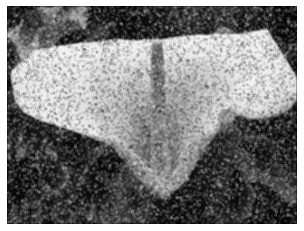

In [7]:
imshow(avg)

### Task 1.2

Implement a more efficient version of averaging filter.

In [8]:
def fast_low_pass(img, k, pad=True):
    img = img.astype('float64')
    const = 1 / (k ** 2)    
    h, w = img.shape
    
    if pad:
        img = add_padding(img, k, k)
        out = np.zeros((h, w))
        out[0][0] = np.sum(img[:k, :k])
        for j in range(1, w):
            out[0][j] = out[0][j-1] + np.sum(img[:k, j+k-1] - img[:k, j-1])
        for i in range(1, h):
            out[i][0] = out[i-1][0] + np.sum(img[i+k-1, :k] - img[i-1, :k])
        for i in range(1, h):
            for j in range(1, w):
                out[i][j] = out[i][j-1]+out[i-1][j]-out[i-1][j-1]+img[i-1][j-1]+img[i+k-1][j+k-1]-img[i+k-1][j-1]-img[i-1][j+k-1]

    else:
        out = np.zeros((h-k+1, w-k+1))
        out[0][0] = np.sum(img[:k, :k])
        for j in range(1, w-k+1):
            out[0][j] = out[0][j-1] + np.sum(img[:k, j+k-1] - img[:k, j-1])
        for i in range(1, h-k+1):
            out[i][0] = out[i-1][0] + np.sum(img[i+k-1, :k] - img[i-1, :k])
        for i in range(1, h-k+1):
            for j in range(1, w-k+1):
                out[i][j] = out[i][j-1]+out[i-1][j]-out[i-1][j-1]+img[i-1][j-1]+img[i+k-1][j+k-1]-img[i+k-1][j-1]-img[i-1][j+k-1]
                
    out *= const            
    return np.clip(np.round(out), 0, 255).astype('uint8')

In [9]:
%time favg = fast_low_pass(noisy, 3)

CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 223 ms


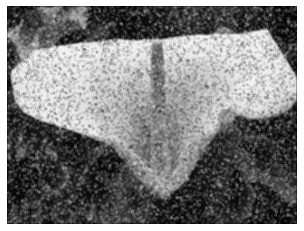

In [10]:
imshow(favg)

### Task 1.3

Generate a plot of k vs run-time for various sized images

In [11]:
efficient_time = []
default_time = []

size = [(2**i, 2**i) for i in range(6, 10)]
K = [k for k in range(3, 10, 2)]

for s in size:
    img = np.random.randint(0, 255, size=s)
    te = []
    td = []
    for k in K:
        st = milli_time()
        fast_low_pass(img, k)
        en = milli_time()
        te.append(en-st)
        st = milli_time()
        low_pass(img, k)
        en = milli_time()
        td.append(en-st)
    efficient_time.append(te)
    default_time.append(td)

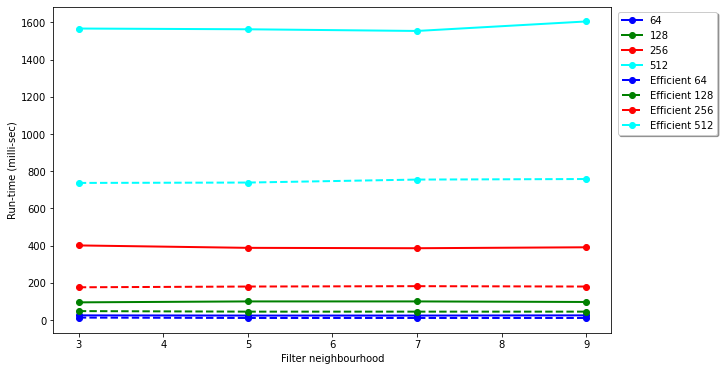

In [12]:
# default graph is solid line, efficient graph is dotted line
plt.figure(figsize=(10, 6))
color = ['blue', 'green', 'red', 'cyan', 'purple']
for i in range(len(size)):
    plt.plot(K, default_time[i], linestyle='-', marker='o', color=color[i], linewidth=2)
legend = [str(s[0]) for s in size]
for i in range(len(size)):
    plt.plot(K, efficient_time[i], linestyle='--', marker='o', color=color[i], linewidth=2)
legend += ['Efficient ' + str(s[0]) for s in size]
plt.xlabel('Filter neighbourhood')
plt.ylabel('Run-time (milli-sec)')
plt.legend(legend, loc='upper center',bbox_to_anchor=(1.1, 1),fancybox=True, shadow=True)
plt.show()

### Task 1.4

Implement an efficient version of a k × k median filter

In [13]:
def fast_median_filter(img, k1, k2):
    h, w = img.shape
    c = k1 * k2 // 2
    img = add_padding(img, k1, k2)
    out = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            out[i][j] = np.sort(img[i:i+k1, j:j+k2].ravel())[c]
    return out.astype('uint8')

def median_filter(img, k1, k2):
    h, w = img.shape
    img = add_padding(img, k1, k2)
    out = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            out[i][j] = np.median(img[i:i+k1, j:j+k2].ravel())
    return np.clip(np.round(out), 0, 255).astype('uint8')

In [86]:
med_def_time = []
med_eff_time = []

size = [2**i for i in range(6, 10)]
K = [k for k in range(3, 10, 2)]

for s in size:
    img = np.random.randint(0, 255, size=(s,s))
    td = []
    te = []
    for k in K:
        st = milli_time()
        median_filter(img, k, k)
        en = milli_time()
        td.append(en - st)
        st = milli_time()
        fast_median_filter(img, k, k)
        en = milli_time()
        te.append(en - st)
    med_def_time.append(td)
    med_eff_time.append(te)

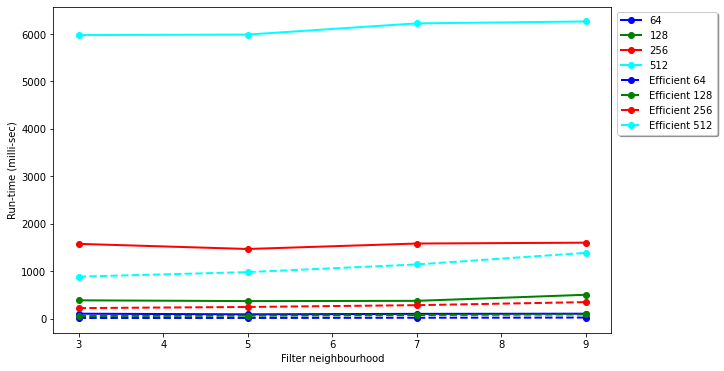

In [87]:
# default graph is solid line, efficient graph is dotted line
plt.figure(figsize=(10, 6))
color = ['blue', 'green', 'red', 'cyan', 'purple']
for i in range(len(size)):
    plt.plot(K, med_def_time[i], linestyle='-', marker='o', color=color[i], linewidth=2)
legend = [str(s) for s in size]
for i in range(len(size)):
    plt.plot(K, med_eff_time[i], linestyle='--', marker='o', color=color[i], linewidth=2)
legend += ['Efficient ' + str(s) for s in size]
plt.xlabel('Filter neighbourhood')
plt.ylabel('Run-time (milli-sec)')
plt.legend(legend, loc='upper center',bbox_to_anchor=(1.1, 1),fancybox=True, shadow=True)
plt.show()

### Task 1.5

Remove noise from Noisy.jpg

CPU times: user 352 ms, sys: 4 ms, total: 356 ms
Wall time: 358 ms


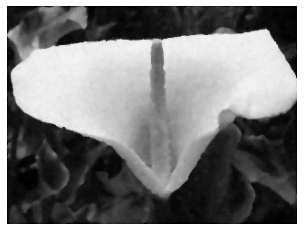

In [16]:
%time imshow(fast_median_filter(noisy, 5, 5))

## Task 2

### Task 2.1

Apply the Canny edge detector (use inbuilt cv2.Canny function for this task) to bell.jpg.

In [17]:
bell = grayimage('bell.jpg')
bell.shape

(512, 343)

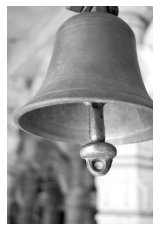

In [18]:
imshow(bell)

### Task 2.2

Report the minVal and maxVal that give the best results for each image.

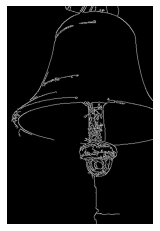

In [19]:
imshow(cv2.Canny(bell, 32, 235))

minVal: 32 <br/>
maxVal: 235

<hr style="border:1px solid gray"> </hr>

### Task 2.3

Implement Roberts, Prewitt, Sobel and Laplacian filters on kobe.png

In [20]:
kobe = grayimage('kobe.png')
kobe.shape

(643, 540)

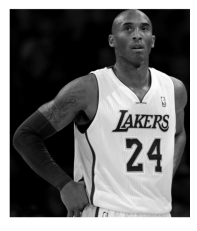

In [21]:
imshow(kobe)

In [22]:
def edge_filter(img, kx, ky):
#     ey = cv2.filter2D(img, -1, ky).astype('float64')
#     ex = cv2.filter2D(img, -1, kx).astype('float64')
    ey = apply_kernel(img, ky).astype('float64')
    ex = apply_kernel(img, kx).astype('float64')
    out = np.clip(np.round(np.sqrt(ex ** 2 + ey ** 2)), 0, 255)
    return out.astype('uint8')

def laplacian(img, ker):
#     return cv2.filter2D(img, -1, ker)
    return apply_kernel(img, ker)

In [23]:
rx = np.array([[0, 1], [-1, 0]])
ry = np.array([[1, 0], [0, -1]])
px = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
py = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
lap1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
lap2 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])

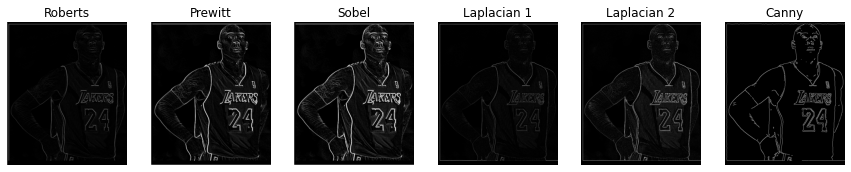

In [24]:
plt.figure(figsize=(15, 6))
plt.subplot(161)
imshow(edge_filter(kobe, rx, ry))
plt.title('Roberts')
plt.subplot(162)
imshow(edge_filter(kobe, px, py))
plt.title('Prewitt')
plt.subplot(163)
imshow(edge_filter(kobe, sx, sy))
plt.title('Sobel')
plt.subplot(164)
imshow(laplacian(kobe, lap1))
plt.title('Laplacian 1')
plt.subplot(165)
imshow(laplacian(kobe, lap2))
plt.title('Laplacian 2')
plt.subplot(166)
imshow(cv2.Canny(kobe, 150, 230))
plt.title('Canny')
plt.show()

Canny edge detector is giving better edges than Prewitt, Sobel, Laplacian as it's able to filter out background and noisy edges and showing dark foreground edges where as others are showing background edges also.


<hr style="border:1px solid gray"> </hr>

### Task 2.4

5×5 variants of Sobel and Prewitt filters

In [25]:
p5x = np.array([[-2, -1, 0, 1, 2], 
                [-2, -1, 0, 1, 2], 
                [-4, -2, 0, 2, 4], 
                [-2, -1, 0, 1, 2], 
                [-2, -1, 0, 1, 2]])
p5y = -p5x.T
s5x = np.array([[9, 9, -7, -7, -7], 
                [9, 5, -3, -3, -7], 
                [9, 5, 0, -3, -7], 
                [9, 5, -3, -3, 7], 
                [9, 9, -7, -7, -7]])
s5y = -s5x.T

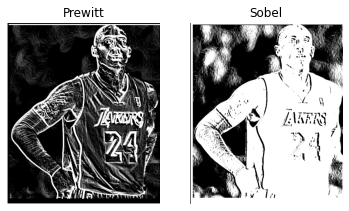

In [26]:
plt.figure(figsize=(6, 6))
plt.subplot(121)
imshow(edge_filter(kobe, p5x, p5y))
plt.title('Prewitt')
plt.subplot(122)
imshow(edge_filter(kobe, s5x, s5y))
plt.title('Sobel')
plt.show()

Large filters are not as good for edge detection as it's giving more thick and background 
edges.

<hr style="border:1px solid gray"> </hr>

### Task 2.5

Add noise to the input image above using Gaussian sampling. Study the effect of applying the above filters(from 2 nd part) on noise-affected inputs.

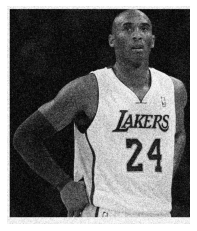

In [27]:
noise = 40 * np.random.normal(size=kobe.shape)
kobe_noisy = np.clip(kobe + noise, 0, 255).astype('uint8')
imshow(kobe_noisy)

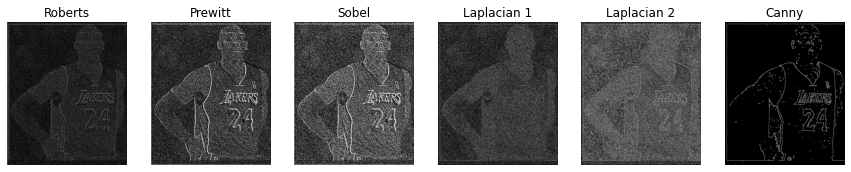

In [28]:
plt.figure(figsize=(15, 6))
plt.subplot(161)
imshow(edge_filter(kobe_noisy, rx, ry))
plt.title('Roberts')
plt.subplot(162)
imshow(edge_filter(kobe_noisy, px, py))
plt.title('Prewitt')
plt.subplot(163)
imshow(edge_filter(kobe_noisy, sx, sy))
plt.title('Sobel')
plt.subplot(164)
imshow(laplacian(kobe_noisy, lap1))
plt.title('Laplacian 1')
plt.subplot(165)
imshow(laplacian(kobe_noisy, lap2))
plt.title('Laplacian 2')
plt.subplot(166)
imshow(cv2.Canny(kobe_noisy, 325, 600))
plt.title('Canny')
plt.show()

After adding noise, we had to increase threshold params of canny edge detector to reduce noisy edges but it's still little noisy. Other edge detectors are also giving lots of noisy edges.

<hr style="border:1px solid gray"> </hr>

## Task 3

In [29]:
mount = image('mountain.jpg')
mount.shape

(388, 291, 3)

In [30]:
def spatial_kernel(k, sigma):
    c = k//2
    v = (np.arange(k).reshape((1,k)) - c) ** 2
    ker = v + v.T
    ker = np.exp(-ker / (2 * (sigma ** 2)))
    return ker/np.sum(ker)

def range_kernel(img, sx, sy, k, sigma):
    cx, cy = sx + k // 2, sy + k // 2
    ker = np.abs(img[sx:sx+k, sy:sy+k] - img[cx][cy]) ** 2
    ker = np.exp(-ker / (2 * (sigma ** 2)))
    return ker/np.sum(ker)

def gaussian_filter(img, k, sig):
    kernel = spatial_kernel(k, sig)
    return apply_kernel(img, kernel)

def bilateral_filter(img, k, sigd, sigr):
    h, w = img.shape
    img = img.astype('float64')
    
    out = np.zeros((h, w))
    img = add_padding(img, k, k)
    ker1 = spatial_kernel(k, sigd)
    
    for i in range(h):
        for j in range(w):
            ker2 = range_kernel(img, i, j, k, sigr)
            ker = ker1 * ker2
            ker /= np.sum(ker)
            out[i][j] = np.sum(img[i:i+k, j:j+k] * ker)
    out = np.clip(np.round(out), 0, 255).astype('uint8')
    return out

def bilateral_filtering(img, k=3, sigd=10, sigr=10):
    if len(img.shape) == 2:
        return bilateral_filter(img, k, sigd, sigr)
    out = bilateral_filter(img[:,:,0], k, sigd, sigr)
    out = np.dstack([out, bilateral_filter(img[:,:,1], k, sigd, sigr)])
    out = np.dstack([out, bilateral_filter(img[:,:,2], k, sigd, sigr)])
    return out

def cross_bilateral_filter(img1, img2, k, sigd, sigr):
    img1 = img1.astype('float64')
    img2 = img2.astype('float64')
    h, w = img1.shape
    
    out = np.zeros((h, w))
    img1 = add_padding(img1, k, k)
    img2 = add_padding(img2, k, k)
    ker1 = spatial_kernel(k, sigd)
    
    for i in range(h):
        for j in range(w):
            ker2 = range_kernel(img2, i, j, k, sigr)
            ker = ker1 * ker2
            ker /= np.sum(ker)
            out[i][j] = np.sum(img1[i:i+k, j:j+k] * ker)
    out = np.clip(np.round(out), 0, 255).astype('uint8')
    return out

def cross_bilateral_filtering(img1, img2, k=3, sigd=10, sigr=10):
    if len(img1.shape) == 2:
        return cross_bilateral_filter(img1, img2, k, sigd, sigr)
    out = cross_bilateral_filter(img1[:,:,0], img2[:,:,0], k, sigd, sigr)
    out = np.dstack([out, cross_bilateral_filter(img1[:,:,1], img2[:,:,1], k, sigd, sigr)])
    out = np.dstack([out, cross_bilateral_filter(img1[:,:,2], img2[:,:,2], k, sigd, sigr)])
    return out


### Task 3.1

Implement Bilateral Filtering and apply it on mountain.jpg

In [31]:
%time bmount = bilateral_filtering(mount, 5, 128, 64)

CPU times: user 9.96 s, sys: 0 ns, total: 9.96 s
Wall time: 9.96 s


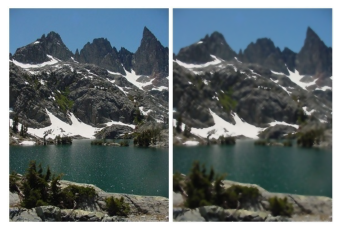

In [32]:
# original vs bilateral filtered image
imshow(np.hstack([mount, bmount]))

In [33]:
# small image for fast testing
test = resize(mount, (80, 100))
print(test.shape)

(100, 80, 3)


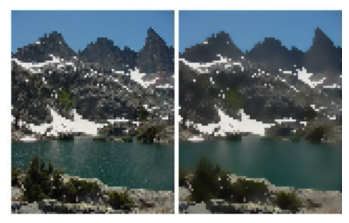

In [34]:
# bilateral filter on small images for fast output
# original vs bilateral filtered image
imshow(np.hstack([test, bilateral_filtering(test, 5, 64, 32)]))

### Task 3.2 - 3.3

Cross Bilateral Filter

In [35]:
cake_noflash = image('cake_noflash.jpg')
cake_flash = image('cake_flash.jpg')
cake_out = image('cake_out.jpg')
print(cake_noflash.shape)
print(cake_flash.shape)
print(cake_out.shape)

(768, 1024, 3)
(768, 1024, 3)
(768, 1024, 3)


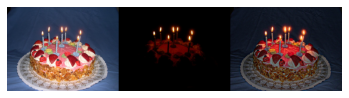

In [36]:
imshow(np.hstack([cake_flash, cake_noflash, cake_out]))

CPU times: user 1min 14s, sys: 51.8 ms, total: 1min 14s
Wall time: 1min 14s


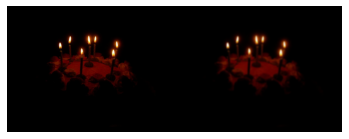

In [37]:
# original vs cross bilateral filtered image
%time imshow(np.hstack([cake_noflash, cross_bilateral_filtering(cake_noflash, cake_flash, 11, 512, 512)]))

(70, 100, 3)


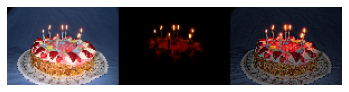

In [38]:
# small images for fast testing
t1 = resize(cake_flash, (100, 70))
t2 = resize(cake_noflash, (100, 70))
t3 = resize(cake_out, (100, 70))
print(t1.shape)
imshow(np.hstack([t1, t2, t3]))

CPU times: user 635 ms, sys: 0 ns, total: 635 ms
Wall time: 633 ms


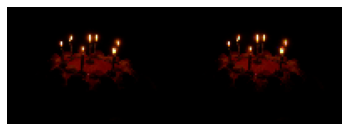

In [39]:
# cross bilateral filter on small images for fast output
# original vs cross bilateral filtered image
%time imshow(np.hstack([t2, cross_bilateral_filtering(t2, t1, 5, 4, 0.1)]))

## Task 4

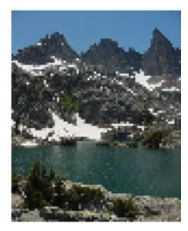

In [40]:
imshow(test)

1. Apply the bilateral filtering to the color image. Keep this filtered image aside for the last step.

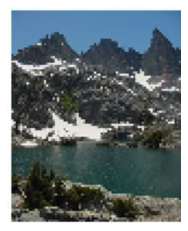

In [41]:
filtered_image = bilateral_filtering(test, 3, 2, 2)
imshow(filtered_image)

2. Now, take a copy of original color image, convert it to gray scale.

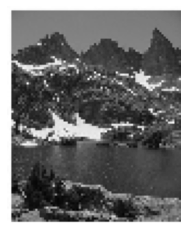

In [42]:
gray_image = rgb2gray(test)
imshow(gray_image)

3. Apply blurring on this gray scale image to reduce noise.

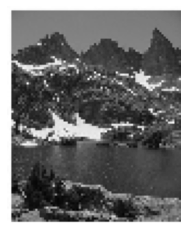

In [43]:
gauss_image = gaussian_filter(gray_image, 3, 0.2)
imshow(gauss_image)

4. Now, create an edge mask from this blurred, gray scale image. An edge mask can be obtained using adaptive thresholding.

In [44]:
def adaptiveThreshold(img, k, c):
    h, w = img.shape
    c = k // 2
    img = add_padding(img, k, k)
    out = np.zeros((h, w), dtype='uint8')
    for i in range(h):
        for j in range(w):
            x = np.mean(img[i:i+k, j:j+k]) - c
            if img[i+c][j+c] <= x:
                out[i][j] = 0
            else:
                out[i][j] = 255
    return out

In [45]:
# mask = cv2.adaptiveThreshold(gauss_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,5,11)
mask = adaptiveThreshold(gauss_image, 5, -11)
mask = mask.reshape((*mask.shape, 1))

5. Combine the bilateral filtered image from step 1 with edge mask(by taking bitwise AND of both at each pixel location).

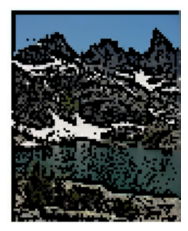

In [46]:
imshow(filtered_image & mask)

## Task 5

(16, 32)


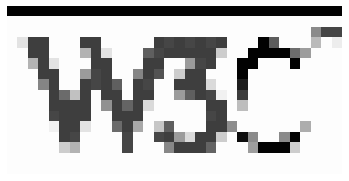

In [47]:
w3c = resize(grayimage('w3c.png'), (32, 16))
print(w3c.shape)
imshow(w3c)

### Task 5.1

Implement 2D DFT.

In [48]:
pi = np.pi

# 2D DFT / IDFT using for loops
def dft2d(img, inv=False):
    M, N = img.shape
    c = -1
    if inv: c = 1
    out = np.zeros((M, N), dtype='complex')
    for m in range(M):
        for n in range(N):
            for x in range(M):
                for y in range(N):
                    out[m][n] += img[x][y] * np.exp(c * 2j * pi * (m * x / M + n * y / N))
    if inv:
        out /= M * N
    return out

# vectorized 2D DFT / IDFT
def dft2d_v(img, inv=False):
    img_shape = img.shape
    img = img.reshape((-1, 1))
    
    # shape of image after flattening image to 1D
    M = img.shape[0]
    # m is used for calculating exp matrix
    m = np.arange(M).reshape((M, 1))
    out = np.zeros((M, 1), dtype='complex')
    
    # max_size of a exp matrix at a time
    max_size = 2 ** 20
    # max columns of exp matrix at a time
    k2 = min(max_size, M)
    # max rows of exp matrix at a time
    k1 = min(max_size // k2, M)
    # range of rows and columns
    l1, r1, l2, r2, c = 0, k1, 0, k2, -1
    # if inverse true, c is 1 otherwise -1
    if inv: c = 1
        
    for _ in range(M//k1+(M%k1!=0)):
        for _ in range(M//k2+(M%k2!=0)):
            out[l1:r1] += np.exp(c * 2j * pi * m[l1:r1, :] @ m[l2:r2,:].T / M) @ img[l2:r2,:]
            l2, r2 = l2 + k2, min(r2 + k2, M)
        l1, r1 = l1 + k1, min(r1 + k1, M)
        
    if inv:
        out /= M
    return out.reshape(img_shape)

In [49]:
%time _ = dft2d(w3c)

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


In [50]:
%time dft = dft2d_v(w3c)

CPU times: user 24.1 ms, sys: 12 µs, total: 24.1 ms
Wall time: 21.4 ms


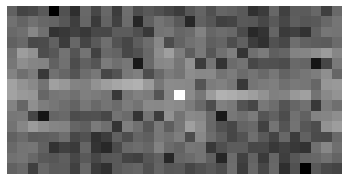

In [51]:
# absolute of dft
imshow(log_map(np.absolute(np.fft.fftshift(dft))))

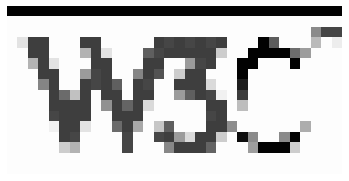

In [52]:
# idft of dft
imshow(np.absolute(dft2d_v(dft, inv=True)))

### Task 5.2 - 5.3

1. Implement 1D, 2D Fast Fourier Transform (Recursive Formulation).
2. Compare the run times of your version of DFT and FFT on different sized inputs and plot them.
3. Implement 2D inverse FFT.

In [53]:
# return power of 2 nearest to n and greater than n
def size2(n):
    return 2 ** int(np.ceil(np.log2(n)))

# resize arr to nearest power of 2
def resize_arr(a):
    if len(a.shape) == 1:
        n = a.shape[0]
        a = np.concatenate([a, np.zeros(size2(n)-n, dtype=a.dtype)])
    else:
        m, n = a.shape
        m1, n1 = size2(m), size2(n)
        a = np.vstack([np.hstack([a, np.zeros((m, n1-n), dtype=a.dtype)]), np.zeros((m1-m,n1), dtype=a.dtype)])
    return a.shape, a

# 1D FFT / IFFT
def fft1D(a, inv=False):
    n = a.shape[0]
    if n == 1:
        return a
    a_even = fft1D(a[::2], inv)
    a_odd = fft1D(a[1::2], inv)
    c = -1
    if inv: c = 1
    w = np.exp(c * 2j * np.pi * np.arange(n) / n)
    out = np.concatenate([a_even + w[:n//2] * a_odd, a_even + w[n//2:] * a_odd])
    if inv:
        out /= 2
    return out

# 2D FFT / IFFT
def fft2D(img, inv=False):
    size, img = resize_arr(img)
    return fft1D(img.ravel(), inv).reshape(size)

# 2D Inverse FFT
def ifft2D(x):
    return fft2D(x, inv=True)

In [54]:
%time fft = fft2D(w3c)

CPU times: user 6.13 ms, sys: 0 ns, total: 6.13 ms
Wall time: 5.87 ms


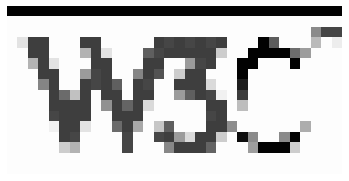

In [55]:
# ifft of fft
imshow(np.absolute(ifft2D(fft)[:w3c.shape[0], :w3c.shape[1]]))

In [56]:
def_time = []
eff_time = []

size = [2**i for i in range(4, 9)]
for s in size:
    img = np.random.randint(0, 255, size=(s, s))
    st = milli_time()
    _ = dft2d_v(img)
    en = milli_time()
    def_time.append(en-st)
    st = milli_time()
    _ = fft2D(img)
    en = milli_time()
    eff_time.append(en-st)

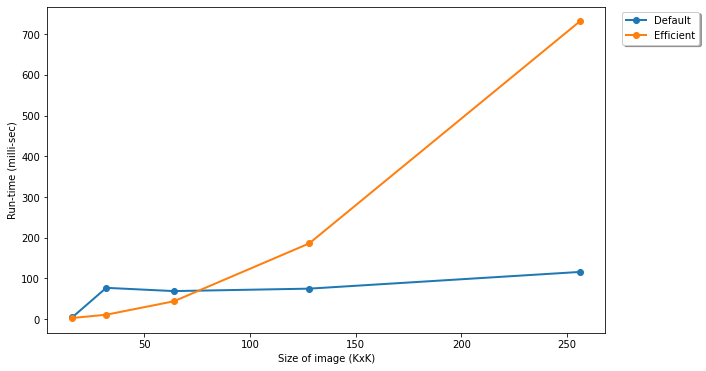

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(size, def_time, linestyle='-', marker='o', linewidth=2)
plt.plot(size, eff_time, linestyle='-', marker='o', linewidth=2)
legend = ['Default', 'Efficient']
plt.xlabel('Size of image (KxK)')
plt.ylabel('Run-time (milli-sec)')
plt.legend(legend, loc='upper center',bbox_to_anchor=(1.1, 1),fancybox=True, shadow=True)
plt.show()

### Task 5.4

Calculate the Fourier transform of the Fourier transform of any image. You would observe that the image you get is similar to the original image. How is it different from the original image? How can you fix this in the frequency domain so that we would get the original image back instead?

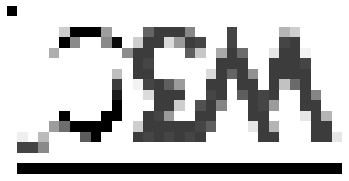

In [58]:
# scaled version of fft of fft
imshow(lin_map(np.absolute(fft2D(fft)[-w3c.shape[0]:, -w3c.shape[1]:])))

After taking fft of fft, resultant image is scaled and inverted and  flipped.

It can be corrected by taking conjugate before and after the second fft.

img -> fft -> output -> conjugate -> fft -> output -> conjugate -> img

<hr style="border:1px solid gray"> </hr>

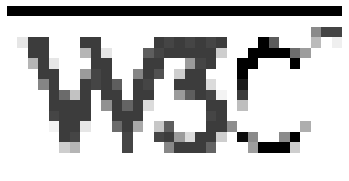

In [59]:
out = np.conj(fft2D(np.conj(fft2D(w3c))))
imshow(lin_map(np.absolute(out)))

## Task 6

In [60]:
f = grayimage('lena.jpg')
h = grayimage('boy.png')
print(f.shape)
print(h.shape)

(256, 256)
(256, 256)


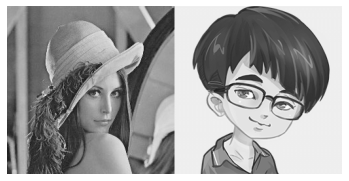

In [61]:
imshow(np.hstack([f, h]))

### Task 6.1 

Compute IFT(F.H) and f * h. Check whether IFT(F.H) corresponds to the center portion of f * h. Compute the average of squared difference between pixel values in IFT(F.H) and the central 256 × 256 portion of f * h (F.H denotes point-wise multiplication of F and H and f * h denotes convolution with padding).

In [62]:
F = fft2D(f)
H = fft2D(h)

In [63]:
IFH = ifft2D(F*H)
fh = apply_kernel(f, np.flip(h) / np.sum(h))

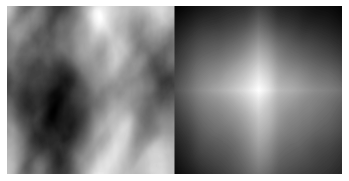

In [64]:
imshow(np.hstack([lin_map(np.absolute(IFH)), lin_map(fh)]))

In [65]:
err = np.mean((np.absolute(IFH) - fh) ** 2)
print('Error:', err)

Error: 1.9704957588153124e+18


Error: 1.9704957588153124e+18

<hr style="border:1px solid gray"> </hr>

### Task 6.2

What changes do you observe when you zero pad the original images to dimension (511 × 511) and now calculate IFT(F.H) and report the new error.

In [66]:
k = 256
fd = add_padding(f, k, k)
hd = add_padding(h, k, k)

In [67]:
Fd = fft2D(fd)
Hd = fft2D(hd)

In [68]:
IFHd = ifft2D(Fd*Hd)[:fd.shape[0], :fd.shape[1]]
fhd = apply_kernel(fd, np.flip(hd) / np.sum(hd))

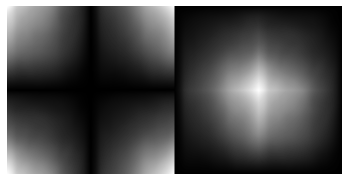

In [69]:
imshow(np.hstack([lin_map(np.absolute(IFHd)), lin_map(fhd)]))

In [70]:
err = np.mean((np.absolute(IFHd) - fhd) ** 2)
print('Error:', err)

Error: 2.0988552060109914e+17


Error: 2.0988552060109914e+17

<hr style="border:1px solid gray"> </hr>

### Task 6.3
 Choose any 64x64 image. Now, add 64 columns and rows of zeros to the right and bottom side of the original image. Repeat this process two more times each time doubling the image size and padding the pixels on the right and bottom by zeroes. You will therefore have 4 images first one 64 × 64 with no zero padding and then 128 × 128, 256 × 256 and 512 × 512 after padding. Find the Fourier transform of all these images. Display the results and explain and justify the relationship between the four outputs you get.

In [71]:
def pad_bottom_right(img, k1, k2):
    m, n = img.shape
    return np.vstack([np.hstack([img, np.zeros((m, k2), dtype=img.dtype)]), np.zeros((k1,n+k2), dtype=img.dtype)])

(64, 64)


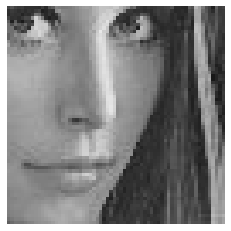

In [72]:
img1 = f[128:192, 128: 192]
print(img1.shape)
imshow(img1)

In [73]:
img2 = pad_bottom_right(img1, 64, 64)
img3 = pad_bottom_right(img2, 128, 128)
img4 = pad_bottom_right(img3, 256, 256)

In [74]:
fft1 = fft2D(img1)
fft2 = fft2D(img2)
fft3 = fft2D(img3)
fft4 = fft2D(img4)

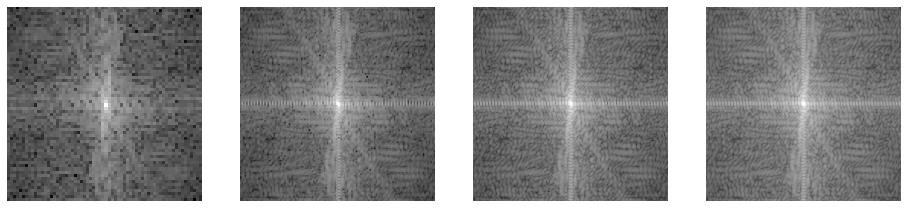

In [75]:
plt.figure(figsize=(16,8))
plt.subplot(141)
imshow(log_map(np.absolute(np.fft.fftshift(fft1))))
plt.subplot(142)
imshow(log_map(np.absolute(np.fft.fftshift(fft2))))
plt.subplot(143)
imshow(log_map(np.absolute(np.fft.fftshift(fft3))))
plt.subplot(144)
imshow(log_map(np.absolute(np.fft.fftshift(fft4))))
plt.show()

Frequencies increased after adding padding.

<hr style="border:1px solid gray"> </hr>

## Task 7

Denoise the given image noisy-lena.png and explain your process.

In [76]:
def max_filter(img, k1, k2):
    h, w = img.shape
    img = add_padding(img, k1, k2)
    out = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            out[i][j] = np.max(img[i:i+k1, j:j+k2])
    return out.astype('uint8')

def min_filter(img, k1, k2):
    h, w = img.shape
    img = add_padding(img, k1, k2)
    out = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            out[i][j] = np.min(img[i:i+k1, j:j+k2])
    return out.astype('uint8')

In [77]:
nlena = grayimage('noisy_lena.png')
print(nlena.shape)

(512, 512)


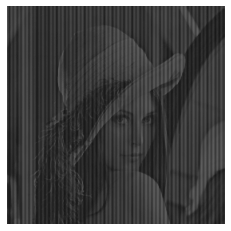

In [78]:
imshow(nlena)

In [79]:
fft = fft2D(nlena)
fabs = log_map(np.absolute(np.fft.fftshift(fft)))

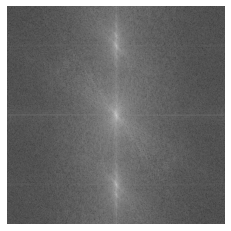

In [80]:
imshow(fabs)

In [81]:
m, n = fabs.shape
# centre is not a noise
nabs = fabs.copy()
nabs[m//2-20:m//2+20, n//2-20:n//2+20] = 0
# finding noise
noise = nabs < np.percentile(nabs, 99)

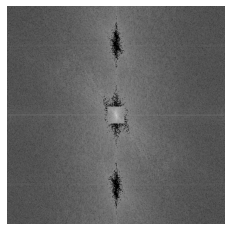

In [82]:
imshow(fabs * noise)

In [83]:
noise = np.fft.ifftshift(noise)

In [84]:
nfft = fft.copy() * noise.astype('int')
ifft = ifft2D(nfft)
out = lin_map(np.absolute(ifft))

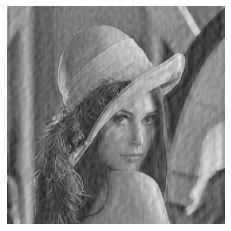

In [85]:
imshow(out)

1. Image converted to frequency domain.
2. Higher noisy frequency is removed. Centre frequencies are not noisy frequencies.
3. Frequency domain to spatial domain

<hr style="border:1px solid gray"> </hr>